# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Боднарюк".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ \frac{\partial L}{\partial w_i} = \dots $$

## Имплементация (5 баллов)

In [230]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=100, error_value_storing=False):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        
        self.error_value_storing = error_value_storing
        if error_value_storing:
            self.error_values = np.zeros(max_epoch, dtype=np.float)
            
        self.X_size = 0
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''

        self.w = np.ones(X.shape[1] + 1).astype(np.float128)
        
        self.X_size = X.shape[0]
       
        return self.fit_core(X, y)
    
    def fit_core(self, X, y=None):
        alpha = self.alpha
        
        X = np.concatenate((np.ones(X.shape[0])[:, None], X), axis=1)
        
        for epoch in xrange(self.max_epoch):
            gs = np.dot(X, self.w)
            sigmas = 1 / (1 + np.exp(-gs))
            lasso = np.sign(self.w) / self.C
            grads = (sigmas - y)[:, None] * X + lasso
            grads_sum = grads.sum(axis=0)
            self.w -= alpha * grads_sum
            alpha = self.alpha / (epoch + 1)
            
            if self.error_value_storing:
                y_gs = y * gs
                er_sigmas = 1 / (1 + np.exp(-gs))
                er_logs_sum = np.log(er_sigmas).sum() / - X.shape[0]
                self.error_values[epoch] = er_logs_sum + lasso.sum()
       
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        
        w_stored = self.w.copy()
        
        self.fit_core(X, y)
        
        new_X_size = X.shape[0]
        new_X_prop = np.float(new_X_size) / (self.X_size + new_X_size)
        self.X_size += new_X_size
        
        self.w = w_stored * (1 - new_X_prop) + self.w * new_X_prop
        
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        
        X = np.concatenate((np.ones(X.shape[0])[:, None], X), axis=1)
        y_hat = (np.dot(X, self.w) > 0).astype(int)
        
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        
        X = np.concatenate((np.ones(X.shape[0])[:, None], X), axis=1)
        # using sigmoid
        y_hat_proba = 1 / (1 + np.exp(-np.dot(X, self.w)))
        return y_hat_proba

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

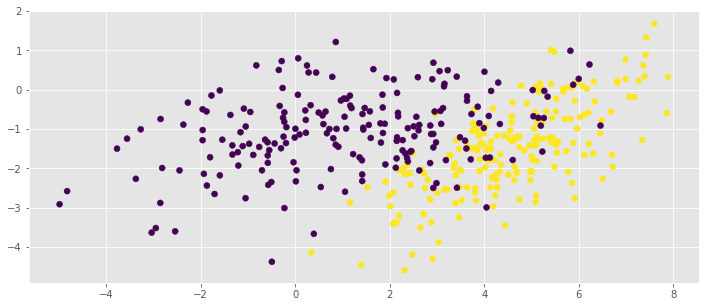

In [4]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [5]:
model = MySGDClassifier(alpha=2e-1, C=100, max_epoch=250, error_value_storing=True)
model.fit(X, y)

MySGDClassifier(C=100, alpha=0.2, error_value_storing=True, max_epoch=250)

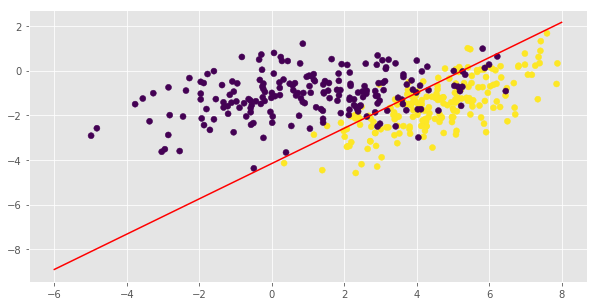

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.scatter(X[:,0], X[:,1], c=y)


xl = np.linspace(-6, 8, 100).reshape(-1, 1)
yl = - (xl * model.w[1] + model.w[0]) / model.w[2]
ax.plot(xl, yl, c='red', label='separator')
# plt.legend()

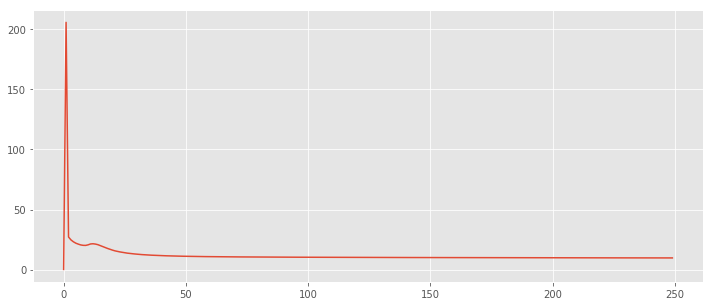

In [7]:
plt.plot(xrange(250), model.error_values)

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [8]:
from sklearn.datasets import make_classification

In [9]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

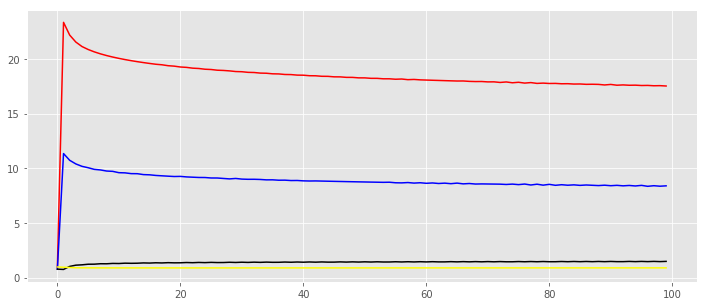

In [10]:
## Your Code Here
# written for epochs
max_epoch = 100
alphas = (
    (0.0002, 'red'),
    (0.0001, 'blue'),
    (0.00001, 'black'),
    (0.000001, 'yellow')
)
for alpha, color in alphas:
    model = MySGDClassifier(alpha=alpha, C=100, max_epoch=100, error_value_storing=True)
    model.fit(X, y)
    plt.plot(xrange(max_epoch), model.error_values, c=color)

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

/home/vasilesk/anaconda3/envs/ipy2/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in exp
/home/vasilesk/anaconda3/envs/ipy2/lib/python2.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in exp
/home/vasilesk/anaconda3/envs/ipy2/lib/python2.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log


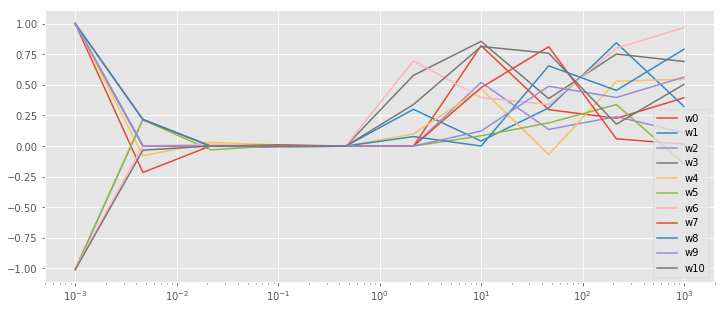

In [11]:
## Your Code Here
c_values = np.logspace(3, -3, 10)
ws = []
for c in c_values:
    model = MySGDClassifier(alpha=0.000001, C=c, max_epoch=100, error_value_storing=True)
    model.fit(X, y)
    ws.append(model.w)

ws = np.array(ws).T
for i, w in enumerate(ws):
    plt.plot(c_values, w, label='w{}'.format(i))
    
plt.xscale('log')
plt.legend()


# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [2]:
# Загрузка данных целиком
# df_list = []
# load_lim = 3
# for chunk in range(1,load_lim):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

filepath = './trainingData_tabular_chunk2.csv'
df_data = pd.concat((df_data, pd.read_csv(filepath, sep=',')))

In [3]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [4]:
df_data.shape

(500000, 44)

In [5]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [6]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.50470199999999998

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [45]:
## Youd Code Here
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.base import TransformerMixin

class Cards_onehot(TransformerMixin):
    def __init__(self):
        self.labels = np.array((u'player_hero_card_id', u'opponent_hero_card_id'))
        self.unique_count = []
        
        self.le = LabelEncoder()
        self.ohe = OneHotEncoder()
        
    def fit_transform(self, X, y=None):
        for label in self.labels:
            uniq_ids = X[label].unique()
            self.unique_count.append(uniq_ids.size)
            X.loc[:, label] = self.le.fit(uniq_ids).transform(X.loc[:, label])

        values = X.loc[:, self.labels]
        encoded_data = self.ohe.fit(values).transform(values).toarray()
        X = X.drop(columns=self.labels)
        t_col_name = 'hero_cards_{}'
        for i, column in enumerate(encoded_data.T):
            X.loc[:, t_col_name.format(i)] = column
        return X
    
    def transform(self, X, y=None):
        for label in self.labels:
            X.loc[:, label] = self.le.transform(X[label])

        values = X.loc[:, self.labels]
        encoded_data = self.ohe.transform(values).toarray()
        X = X.drop(columns=self.labels)
        t_col_name = 'hero_cards_{}'
        for i, column in enumerate(encoded_data.T):
            X.loc[:, t_col_name.format(i)] = column
        return (X - X.mean()) / (X.max() - X.min())
    
    def print_unique_count(self):
        for i, label in enumerate(self.labels):
            print('Number of unique {} is {}'.format(label, self.unique_count[i]))

In [46]:
cards_onehot = Cards_onehot()

X_real, y_real = cards_onehot.fit_transform(df_data.iloc[:,1:]), df_data.iloc[:,0].values

cards_onehot.print_unique_count()

Number of unique player_hero_card_id is 9
Number of unique opponent_hero_card_id is 9


In [47]:
X_real.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
turn,14.0,7.0,5.0,8.0,13.0
opponent_armor,0.0,0.0,3.0,0.0,0.0
opponent_attack,0.0,0.0,0.0,0.0,0.0
opponent_hp,5.0,22.0,29.0,26.0,30.0
opponent_special_skill_used,0.0,0.0,0.0,0.0,0.0
opponent_weapon_durability,0.0,0.0,0.0,0.0,0.0
opponent_crystals_all,10.0,6.0,4.0,7.0,10.0
opponent_crystals_current,10.0,6.0,1.0,7.0,1.0
opponent_deck_count,11.0,19.0,22.0,17.0,12.0
opponent_fatigue_damage,0.0,0.0,0.0,0.0,0.0


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [231]:
## Youd Code Here
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

max_epoch = 100

scaler = StandardScaler()

alpha=np.float128(0.00000001)
sgd = MySGDClassifier(alpha=alpha, C=10, max_epoch=max_epoch, error_value_storing=True)

pipe = make_pipeline(scaler, sgd).fit(X_real[:2000], y_real[:2000])

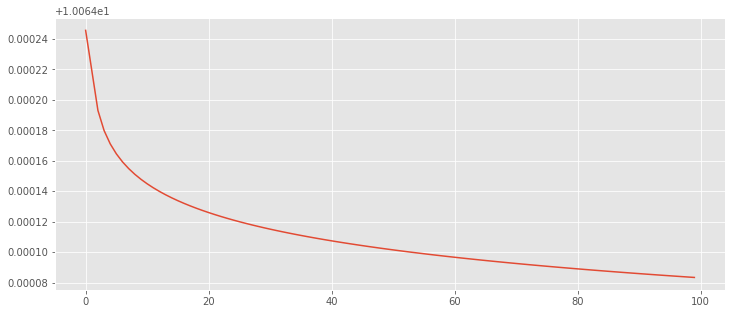

In [232]:
plt.plot(xrange(max_epoch), pipe.steps[1][1].error_values)

In [126]:
scaler2 = StandardScaler()
sgd2 = MySGDClassifier(alpha=0.00000001, C=10, max_epoch=max_epoch, error_value_storing=True)

pipe2 = make_pipeline(scaler2, sgd2).fit(X_real[:2000], y_real[:2000])
y_pred2 = pipe2.predict(X_real[:2000])

print 'ROC AUC value: {}'.format(roc_auc_score(y_real[:2000], y_pred2))

ROC AUC value: 0.510414165666


In [227]:
sgd2 = MySGDClassifier(alpha=alpha, C=10, max_epoch=max_epoch, error_value_storing=True)
sgd3 = MySGDClassifier(alpha=alpha, C=10, max_epoch=max_epoch, error_value_storing=True)
sgd2.fit(X_real[:2000], y_real[:2000])
sgd3.fit(X_real[:2000], y_real[:2000])
sgd2.predict(X_real[:2000]) == sgd3.predict(X_real[:2000])
scaler3 = StandardScaler()
scaler3.fit(X_real[:2000])
pipe2 = make_pipeline(scaler3,sgd2).fit(X_real[:2000], y_real[:2000])
pipe3 = make_pipeline(scaler3,sgd3).fit(X_real[:2000], y_real[:2000])
(pipe2.predict(X_real[:2000]) == pipe3.predict(X_real[:2000])).sum()

1537

In [224]:
alpha=np.float128(0.0001)
sgd2 = MySGDClassifier(alpha=alpha, C=100, max_epoch=max_epoch, error_value_storing=True)
sgd3 = MySGDClassifier(alpha=alpha, C=100, max_epoch=max_epoch, error_value_storing=True)
sgd2.fit(X_real[:2000], y_real[:2000])
sgd3.fit(X_real[:2000], y_real[:2000])
scaler3 = StandardScaler()
new_X = scaler3.fit_transform(X_real[:2000])
(sgd3.predict(new_X[:2000]) == sgd3.predict(new_X[:2000])).sum()

2000

In [135]:
y_real

array([1, 1, 1, ..., 1, 0, 0])

In [223]:
from sklearn.metrics import roc_auc_score
y_pred = pipe.predict(X_real[:2000])

print 'ROC AUC value: {}'.format(roc_auc_score(y_real[:2000], y_pred))

ROC AUC value: 0.521768707483


## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [21]:
## Youd Code Here
df_test_list = []
for chunk in xrange(5,6):
    filepath = 'testData_tabular_chunk{}.csv'.format(chunk)
    df_test_list.append(pd.read_csv(filepath, sep=','))
df_test_data = pd.concat(df_test_list)

df_test_data.columns = df_test_data.columns.str.replace('.', '_')
df_test_data = df_test_data.set_index('gamestate_id')
df_test_data = cards_onehot.transform(df_test_data)
df_test_data.shape

(500000, 60)

In [22]:
df_test_data.head().T

gamestate_id,1304374,4383331,3544947,4282915,4327924
decision,NaN,NaN,NaN,NaN,NaN
turn,5.0,9.0,16.0,3.0,5.0
opponent_armor,0.0,0.0,0.0,0.0,0.0
opponent_attack,0.0,3.0,0.0,0.0,0.0
opponent_hp,23.0,16.0,16.0,30.0,30.0
opponent_special_skill_used,0.0,0.0,1.0,0.0,0.0
opponent_weapon_durability,0.0,1.0,0.0,0.0,0.0
opponent_crystals_all,4.0,8.0,10.0,2.0,4.0
opponent_crystals_current,0.0,3.0,2.0,2.0,1.0
opponent_deck_count,21.0,17.0,9.0,24.0,22.0


In [23]:
from sklearn.metrics import roc_auc_score

y_true = np.loadtxt('deprecated_testLabels.txt')
X_test = df_test_data.iloc[:,1:].values

y_pred = pipe.predict(X_test)

print 'ROC AUC value: {}'.format(roc_auc_score(y_true[:500000], y_pred))

ROC AUC value: 0.643261005881


In [25]:
filepath = './trainingData_tabular_chunk1.csv'
X_true = pd.read_csv(filepath, sep=',')
X_true.columns = X_true.columns.str.replace('.', '_')
X_true = X_true.set_index('gamestate_id')

X_true = cards_onehot.fit_transform(X_true)
X_true, y_true = X_true.iloc[:,1:].values, X_true.iloc[:,0].values

y_pred = pipe.predict(X_true)
print 'ROC AUC value: {}'.format(roc_auc_score(y_true, y_pred))

ROC AUC value: 0.641174600686
